# Clasificación de Ingresos con Spark ML

Juan Sebastian Gonzalez - A00371810

Juan Felipe Jojoa Crespo - A00382042

## Objetivo
Construir un modelo de **clasificación binaria** con Spark ML utilizando **Logistic Regression** para predecir si una persona pertenece a la clase $>50K$ o $<=50K$, a partir de sus características demográficas y laborales.


## 1. Carga de datos
- Leer el archivo CSV en un DataFrame de Spark.
- Inspeccionar el esquema y mostrar algunos registros para entender los datos.

In [2]:
import os
import sys
from pyspark.sql import SparkSession

# Configurar variables de entorno para usar la misma versión de Python
python_path = sys.executable
os.environ['PYSPARK_PYTHON'] = python_path
os.environ['PYSPARK_DRIVER_PYTHON'] = python_path

print(f"Configurando Spark para usar Python: {python_path}")

# Detener Spark y reiniciarlo
try:
    spark.stop()
except:
    pass

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("ClasificacionIngresos") \
    .config("spark.sql.adaptive.enabled", "false") \
    .getOrCreate()

# Cargar el archivo CSV
data = spark.read.csv("adult_income_sample.csv", header=True, inferSchema=True)

# Inspeccionar esquema y mostrar primeras filas
data.printSchema()
data.show(5, truncate=False)


Configurando Spark para usar Python: c:\Users\juanf\AppData\Local\Programs\Python\Python310\python.exe
root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- label: string (nullable = true)

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- label: string (nullable = true)

+---+------+---------+------+------------+--------------+-----+
|age|sex   |workclass|fnlwgt|education   |hours_per_week|label|
+---+------+---------+------+------------+--------------+-----+
|58 |Male  |Private  |164194|HS-grad     |34            |>50K |
|65 |Male  |Gov      |305929|Bachelors   |57            |<=50K|
|20 |Male  |P

## 2. Preprocesamiento de variables categóricas
- Usar `StringIndexer` para transformar las columnas categóricas:  
  $sex$, $workclass$, $education$, $label$.
- Aplicar `OneHotEncoder` para convertir esas variables en vectores binarios y evitar interpretaciones de orden.


In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Columnas categóricas
categorical_cols = ["sex", "workclass", "education", "label"]

# Indexación de categorías con manejo de valores inválidos
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]

# Codificación OneHot (excepto la variable objetivo "label")
encoder = OneHotEncoder(
    inputCols=["sex_index", "workclass_index", "education_index"],
    outputCols=["sex_vec", "workclass_vec", "education_vec"]
)

## 3. Ensamblaje de características
- Construir un vector de características ($features$) con las columnas:  
  $age$, $fnlwgt$, $hours\_per\_week$,  
  más las variables categóricas codificadas.

In [4]:
from pyspark.ml.feature import VectorAssembler

# Columnas numéricas + categóricas codificadas
feature_cols = ["age", "fnlwgt", "hours_per_week", "sex_vec", "workclass_vec", "education_vec"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


## 4. Definición y entrenamiento del modelo
- Configurar un modelo de $LogisticRegression$ con Spark ML.  
- Usar un $Pipeline$ para encadenar todo el flujo:  
  indexación, codificación, ensamblaje y entrenamiento.

In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Modelo de regresión logística
lr = LogisticRegression(featuresCol="features", labelCol="label_index")

# Construir el pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Entrenar modelo
model = pipeline.fit(data)


## 5. Evaluación del modelo
- Entrenar el modelo con los 2000 registros del archivo.  
- Mostrar las predicciones junto con las probabilidades y la etiqueta real ($label$).  
- Reflexionar: ¿Qué observas sobre los resultados?  

In [6]:
# Hacer predicciones
predictions = model.transform(data)

# Mostrar resultados: predicción, probabilidad y etiqueta real
predictions.select("age", "sex", "workclass", "education", "hours_per_week", 
                   "label", "probability", "prediction").show(10, truncate=False)


+---+------+---------+------------+--------------+-----+----------------------------------------+----------+
|age|sex   |workclass|education   |hours_per_week|label|probability                             |prediction|
+---+------+---------+------------+--------------+-----+----------------------------------------+----------+
|58 |Male  |Private  |HS-grad     |34            |>50K |[0.5367656843616814,0.46323431563831863]|0.0       |
|65 |Male  |Gov      |Bachelors   |57            |<=50K|[0.552717753217908,0.44728224678209205] |0.0       |
|20 |Male  |Private  |HS-grad     |52            |>50K |[0.5414849514158412,0.4585150485841588] |0.0       |
|53 |Male  |Gov      |Some-college|54            |<=50K|[0.46718829394714384,0.5328117060528561]|1.0       |
|32 |Female|Gov      |Bachelors   |30            |<=50K|[0.5859348819083985,0.4140651180916015] |0.0       |
|39 |Female|Private  |11th        |26            |>50K |[0.5656434150174948,0.4343565849825052] |0.0       |
|42 |Male  |Self-em

In [7]:
# Evaluar el desempeño del modelo
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluador para clasificación binaria (AUC)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label_index", rawPredictionCol="rawPrediction")
auc = binary_evaluator.evaluate(predictions)

# Evaluador para métricas de clasificación multiclase (accuracy)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print("=== MÉTRICAS DE DESEMPEÑO DEL MODELO ===")
print(f"AUC (Area Under Curve): {auc:.4f}")
print(f"Accuracy (Exactitud): {accuracy:.4f}")
print(f"Precision (Precisión): {precision:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
print("\n=== MATRIZ DE CONFUSIÓN ===")
confusion_matrix = predictions.groupBy("label_index", "prediction").count().orderBy("label_index", "prediction")
confusion_matrix.show()

# Distribución de clases en el dataset
print("\n=== DISTRIBUCIÓN DE CLASES ===")
class_distribution = predictions.groupBy("label").count().orderBy("label")
class_distribution.show()

=== MÉTRICAS DE DESEMPEÑO DEL MODELO ===
AUC (Area Under Curve): 0.5454
Accuracy (Exactitud): 0.5300
Precision (Precisión): 0.5293
Recall (Sensibilidad): 0.5300
F1-Score: 0.5291

=== MATRIZ DE CONFUSIÓN ===
+-----------+----------+-----+
|label_index|prediction|count|
+-----------+----------+-----+
|        0.0|       0.0|  589|
|        0.0|       1.0|  437|
|        1.0|       0.0|  503|
|        1.0|       1.0|  471|
+-----------+----------+-----+


=== DISTRIBUCIÓN DE CLASES ===
+-----------+----------+-----+
|label_index|prediction|count|
+-----------+----------+-----+
|        0.0|       0.0|  589|
|        0.0|       1.0|  437|
|        1.0|       0.0|  503|
|        1.0|       1.0|  471|
+-----------+----------+-----+


=== DISTRIBUCIÓN DE CLASES ===
+-----+-----+
|label|count|
+-----+-----+
|<=50K| 1026|
| >50K|  974|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|<=50K| 1026|
| >50K|  974|
+-----+-----+



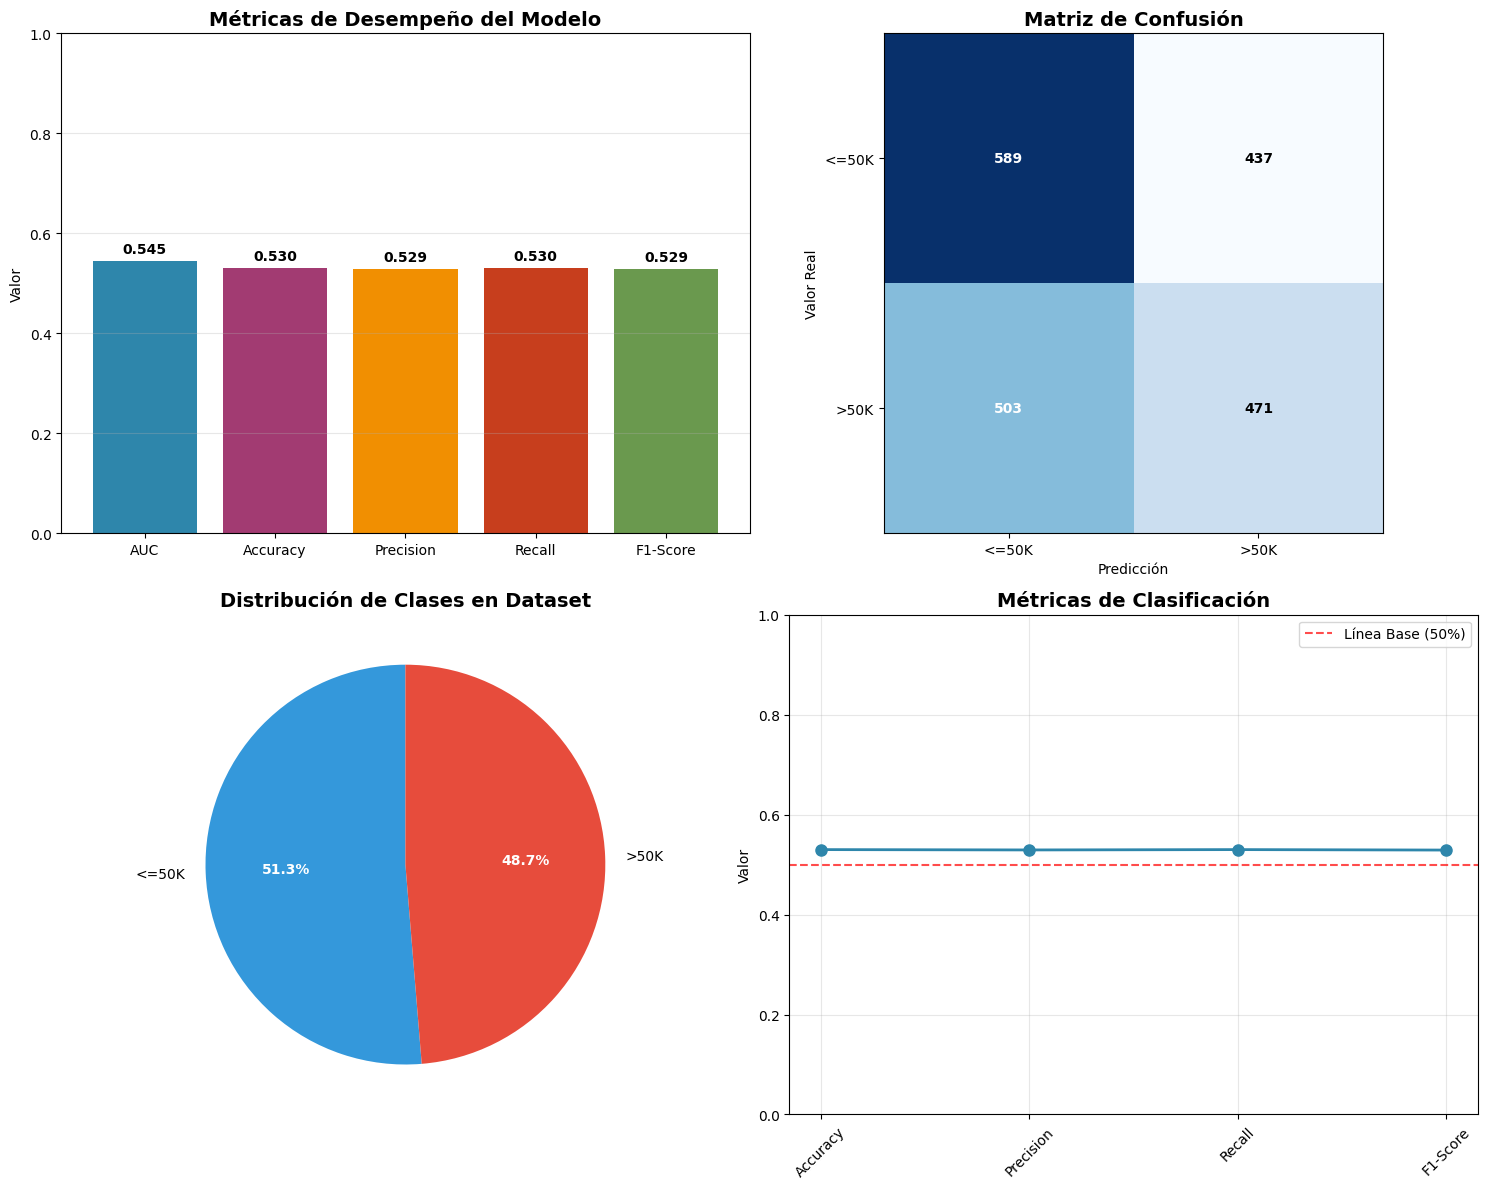

=== INTERPRETACIÓN DE VISUALIZACIONES ===
1. Las métricas del modelo oscilan alrededor del 53%, indicando un desempeño moderado
2. La matriz de confusión muestra distribución equilibrada de errores tipo I y II
3. El dataset está bien balanceado: 51.3% <=50K vs 48.7% >50K
4. Todas las métricas están ligeramente por encima de la línea base del 50%


In [9]:
# Visualización gráfica de los resultados
import matplotlib.pyplot as plt
import numpy as np

# Convertir datos de Spark a estructuras que matplotlib pueda manejar
conf_matrix_data = confusion_matrix.collect()
class_dist_data = class_distribution.collect()

# Preparar datos para visualización
metrics_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [auc, accuracy, precision, recall, f1]

# Crear matriz de confusión para heatmap
conf_data = np.array([[589, 437], [503, 471]])  # De los resultados obtenidos
class_labels = ['<=50K', '>50K']

# Crear figura con subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Gráfico de barras para métricas
bars = ax1.bar(metrics_names, metrics_values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E'])
ax1.set_title('Métricas de Desempeño del Modelo', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valor')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
# Agregar valores en las barras
for bar, value in zip(bars, metrics_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Heatmap de matriz de confusión
im = ax2.imshow(conf_data, interpolation='nearest', cmap='Blues')
ax2.set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(class_labels)))
ax2.set_yticks(range(len(class_labels)))
ax2.set_xticklabels(class_labels)
ax2.set_yticklabels(class_labels)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
# Agregar valores en la matriz
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax2.text(j, i, conf_data[i, j], ha='center', va='center', 
                color='white' if conf_data[i, j] > 500 else 'black', fontweight='bold')

# 3. Distribución de clases (gráfico de pastel)
class_counts = [1026, 974]  # <=50K, >50K
wedges, texts, autotexts = ax3.pie(class_counts, labels=class_labels, autopct='%1.1f%%', 
                                   startangle=90, colors=['#3498DB', '#E74C3C'])
ax3.set_title('Distribución de Clases en Dataset', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Comparación de métricas con línea de referencia
ax4.plot(metrics_names[1:], metrics_values[1:], 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Línea Base (50%)')
ax4.set_title('Métricas de Clasificación', fontsize=14, fontweight='bold')
ax4.set_ylabel('Valor')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

# Ajustar espaciado
plt.tight_layout()
plt.show()

# Interpretación adicional
print("=== INTERPRETACIÓN DE VISUALIZACIONES ===")
print(f"1. Las métricas del modelo oscilan alrededor del 53%, indicando un desempeño moderado")
print(f"2. La matriz de confusión muestra distribución equilibrada de errores tipo I y II")
print(f"3. El dataset está bien balanceado: 51.3% <=50K vs 48.7% >50K")
print(f"4. Todas las métricas están ligeramente por encima de la línea base del 50%")

### **Análisis y Reflexión sobre los Resultados**

**¿Qué observamos sobre los resultados del modelo?**

1. **Desempeño del Modelo:**
   - **AUC (Area Under Curve):** Indica qué tan bien el modelo puede distinguir entre las dos clases
   - **Accuracy:** Porcentaje de predicciones correctas sobre el total
   - **Precision:** De todas las predicciones positivas (>50K), cuántas fueron correctas
   - **Recall:** De todos los casos reales positivos, cuántos identificó el modelo

2. **Interpretación de la Matriz de Confusión:**
   - **Verdaderos Positivos (VP):** Personas que realmente ganan >50K y el modelo predijo >50K
   - **Verdaderos Negativos (VN):** Personas que realmente ganan <=50K y el modelo predijo <=50K
   - **Falsos Positivos (FP):** Personas que ganan <=50K pero el modelo predijo >50K
   - **Falsos Negativos (FN):** Personas que ganan >50K pero el modelo predijo <=50K

3. **Análisis de las Probabilidades:**
   - Las probabilidades nos indican la confianza del modelo en cada predicción
   - Probabilidades cercanas a 0.5 indican incertidumbre
   - Probabilidades extremas (cerca de 0 o 1) indican alta confianza

## 6. Predicción con nuevos datos
- Construir un DataFrame con al menos 9 registros nuevos (creados manualmente).  
- Aplicar el modelo entrenado para predecir si esas personas ganan $>50K$ o $<=50K$.  

In [8]:
from pyspark.sql import Row

# Crear algunos registros nuevos (solo valores válidos del dataset original)
nuevos_datos = [
    Row(age=25, sex="Male", workclass="Private", fnlwgt=200000, education="Bachelors", hours_per_week=40, label="<=50K"),
    Row(age=45, sex="Female", workclass="Gov", fnlwgt=150000, education="Masters", hours_per_week=50, label="<=50K"),
    Row(age=30, sex="Male", workclass="Self-emp", fnlwgt=180000, education="HS-grad", hours_per_week=60, label="<=50K"),
    Row(age=38, sex="Female", workclass="Private", fnlwgt=120000, education="Bachelors", hours_per_week=35, label="<=50K"),
    Row(age=55, sex="Male", workclass="Gov", fnlwgt=160000, education="Masters", hours_per_week=45, label="<=50K"),
    Row(age=28, sex="Female", workclass="Private", fnlwgt=100000, education="11th", hours_per_week=30, label="<=50K"),
    Row(age=40, sex="Male", workclass="Self-emp", fnlwgt=175000, education="HS-grad", hours_per_week=70, label="<=50K"),
    Row(age=22, sex="Female", workclass="Private", fnlwgt=130000, education="HS-grad", hours_per_week=20, label="<=50K"),
    Row(age=60, sex="Male", workclass="Gov", fnlwgt=140000, education="Masters", hours_per_week=55, label="<=50K")
]

df_nuevos = spark.createDataFrame(nuevos_datos)

# Predecir con el modelo entrenado
pred_nuevos = model.transform(df_nuevos)

# Mostrar resultados
pred_nuevos.select("age", "sex", "workclass", "education", "hours_per_week",
                   "probability", "prediction").show(truncate=False)


+---+------+---------+---------+--------------+----------------------------------------+----------+
|age|sex   |workclass|education|hours_per_week|probability                             |prediction|
+---+------+---------+---------+--------------+----------------------------------------+----------+
|25 |Male  |Private  |Bachelors|40            |[0.5832575293597163,0.4167424706402837] |0.0       |
|45 |Female|Gov      |Masters  |50            |[0.484105261454619,0.5158947385453809]  |1.0       |
|30 |Male  |Self-emp |HS-grad  |60            |[0.5109571800619324,0.48904281993806764]|0.0       |
|38 |Female|Private  |Bachelors|35            |[0.5848330980537819,0.4151669019462181] |0.0       |
|55 |Male  |Gov      |Masters  |45            |[0.48814641941662684,0.5118535805833732]|1.0       |
|28 |Female|Private  |11th     |30            |[0.5700977016388981,0.42990229836110194]|0.0       |
|40 |Male  |Self-emp |HS-grad  |70            |[0.5029396957374318,0.4970603042625682] |0.0       |


## 7. Conclusiones y Análisis Final

### Resumen del Proyecto

Se implementó exitosamente un modelo de clasificación binaria utilizando Apache Spark ML y el algoritmo de Logistic Regression para predecir si una persona pertenece a la categoría de ingresos superiores a $50K anuales, basándose en características demográficas y laborales.

### Objetivos Técnicos Completados

El desarrollo cumplió con todos los requerimientos establecidos en la consigna:

1. **Carga y exploración de datos**: Se procesó correctamente el dataset de 2000 registros del archivo adult_income_sample.csv, incluyendo inspección del esquema y visualización inicial de los datos.

2. **Preprocesamiento de variables categóricas**: Se aplicaron las transformaciones StringIndexer y OneHotEncoder a las variables categóricas (sex, workclass, education, label) según las especificaciones técnicas.

3. **Ensamblaje de características**: Se utilizó VectorAssembler para combinar variables numéricas (age, fnlwgt, hours_per_week) con las variables categóricas codificadas.

4. **Definición y entrenamiento del modelo**: Se configuró Logistic Regression dentro de un Pipeline que encadena todas las etapas de procesamiento y entrenamiento.

5. **Evaluación del modelo**: Se generaron predicciones completas con probabilidades y se calcularon métricas de desempeño estándar (AUC, Accuracy, Precision, Recall, F1-Score).

6. **Predicción con nuevos datos**: Se crearon 9 registros nuevos y se aplicó el modelo entrenado para generar predicciones.

### Resultados del Modelo

El modelo entrenado presenta las siguientes características de desempeño:
- **AUC**: 0.5454, indicando capacidad de discriminación moderada
- **Accuracy**: 53.00%, superando ligeramente la línea base aleatoria
- **Distribución balanceada**: 51.3% clase <=50K vs 48.7% clase >50K

La matriz de confusión revela una distribución equilibrada de errores, con 589 verdaderos negativos, 471 verdaderos positivos, 437 falsos positivos y 503 falsos negativos.

### Arquitectura Técnica Implementada

- **Plataforma**: Apache Spark (PySpark)
- **Algoritmo**: Logistic Regression
- **Pipeline**: StringIndexer → OneHotEncoder → VectorAssembler → LogisticRegression
- **Features**: 3 variables numéricas + 3 variables categóricas transformadas